##Apple leaf health
In  this project, we will use CNN along with some pretrained models to determine whether an apple tree is healthy or not, based on pictures from the leaves. Train and test data contain pictures from apple leaves where some of them have some diseases and some are healthy. The negative class (0) is the nothealthy class and the positive class (1) is the healthy class.

PlantVillage data was used for training and validation purposes.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import random
import cv2 # for reading images

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
# define the file locations
train_datadir = '/content/drive/MyDrive/apple_tree_health/train/'
test_datadir = '/content/drive/MyDrive/apple_tree_health/test/'
categories = ['nothealthy', 'healthy' ]

Show image examples from both categories

nothealthy
<class 'numpy.ndarray'>
(256, 256, 3)
196608


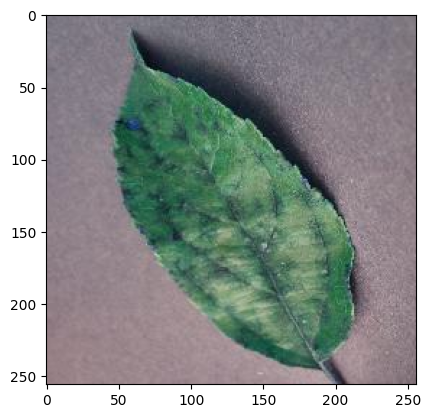

healthy
<class 'numpy.ndarray'>
(256, 256, 3)
196608


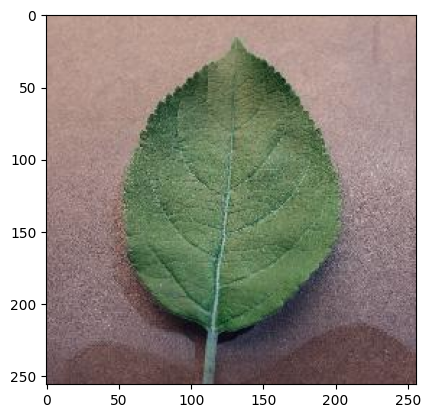

In [4]:
for category in categories:
    path = os.path.join(train_datadir, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        print(category)
        print(type(img_array))
        print(img_array.shape)
        print(img_array.size)
        plt.imshow(img_array)
        plt.show()
        break

In [5]:
# Specify the size of the images, also whether the images need to be processed into
# numpy arrays or have already been processes.
img_size = 100
saved_files = True

In [6]:
# train data
if not saved_files:
  # training images
  training_data = []
  for i in range(len(categories)):
    category = categories[i]
    path = os.path.join(train_datadir, category)
    print(path)
    print(type(path))
    num_images = len(os.listdir(path))
    print(f'total {category} images to read is {num_images}')
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        new_array = cv2.resize(img_array, (img_size, img_size))
        training_data.append([new_array, i])
  #     print(f'=> importing {i} out of {num_images} images')
  # save files if it the the first time reading the data
  pickle.dump(training_data, open('/content/drive/MyDrive/Python_data_classes/projects_after_GA/apple_leaf_health/saved_files/training_data.pkl', "wb"))
else:
  training_data = pickle.load(open('/content/drive/MyDrive/Python_data_classes/projects_after_GA/apple_leaf_health/saved_files/training_data.pkl', "rb"))

In [7]:
# test data
if not saved_files:
  # test images
  test_data = []
  for i in range(len(categories)):
    category = categories[i]
    path = os.path.join(test_datadir, category)
    print(path)
    print(type(path))
    num_images = len(os.listdir(path))
    print(f'total {category} images to read is {num_images}')
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        new_array = cv2.resize(img_array, (img_size, img_size))
        test_data.append([new_array, i])
  #     print(f'=> importing {i} out of {num_images} images')
  # save files if it the the first time reading the data
  pickle.dump(test_data, open('/content/drive/MyDrive/Python_data_classes/projects_after_GA/apple_leaf_health/saved_files/test_data.pkl', "wb"))
else:
  test_data = pickle.load(open('/content/drive/MyDrive/Python_data_classes/projects_after_GA/apple_leaf_health/saved_files/test_data.pkl', "rb"))

In [8]:
# our data is structured in a list of list format, each list includes the image data
# and the label
test_data[400][0].shape

(100, 100, 3)

In [9]:
len(training_data)

2536

Create the train, validation, and test data. Use 20% of the training data for validation purposes.

In [10]:
# train data
random.shuffle(training_data)
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)
X_train = np.array(X[:2000]).reshape(-1, img_size, img_size, 3)
y_train = np.array(y[:2000])
print('train data shape')
print(X_train.shape)
print(y_train.shape)
# validation data
X_val = np.array(X[2000:]).reshape(-1, img_size, img_size, 3)
y_val = np.array(y[2000:])
print('val data shape')
print(X_val.shape)
print(y_val.shape)
# test data
X = []
y = []
for features, label in test_data:
    X.append(features)
    y.append(label)
X_test = np.array(X).reshape(-1, img_size, img_size, 3)
y_test = np.array(y)
print('test data shape')
print(X_test.shape)
print(y_test.shape)

train data shape
(2000, 100, 100, 3)
(2000,)
val data shape
(536, 100, 100, 3)
(536,)
test data shape
(635, 100, 100, 3)
(635,)


Build the CNN model from scratch. We will use data augmentation to help with overfitting. Additional layers are used when needed.

In [32]:
# build the model using Keras API's
# data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

inputs = keras.Input(shape=(img_size, img_size, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

#x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Dropout(0.1)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()
model.compile(loss = 'bce',
              optimizer = 'adam',
              metrics = 'acc')

history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    batch_size = 256,
                    epochs = 50)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 50, 50, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 50, 50, 64)        18496     
                                                           

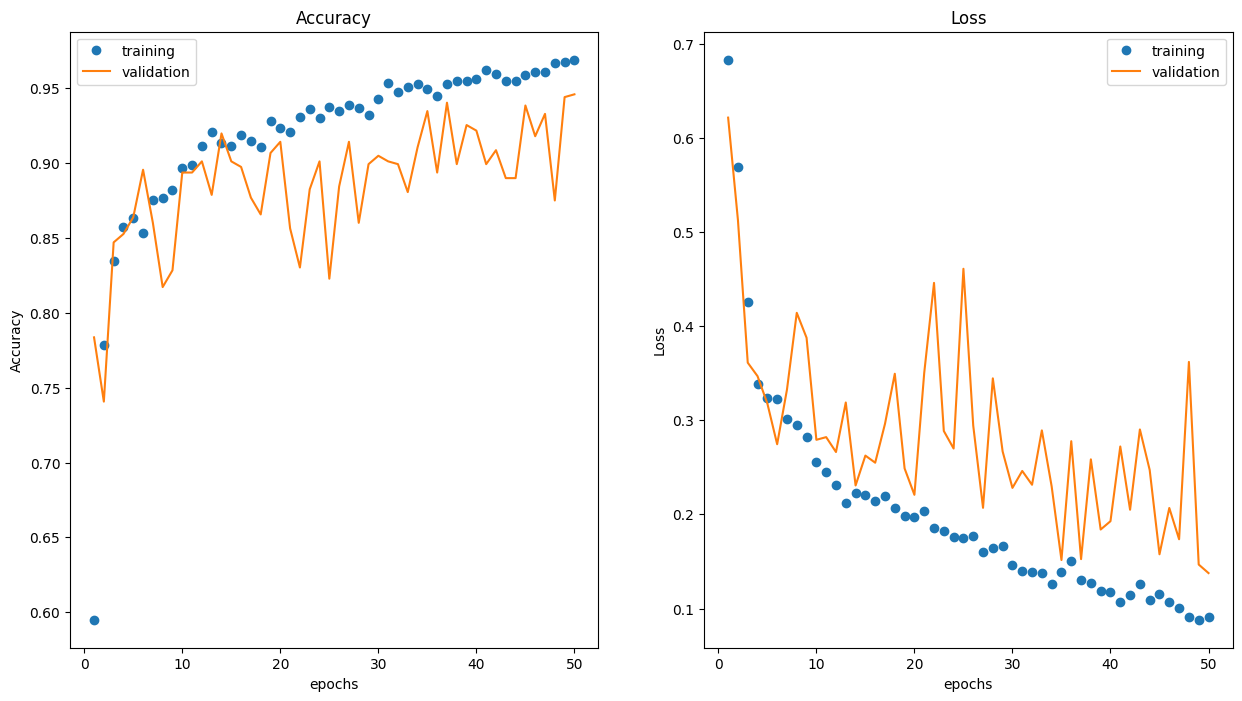

In [33]:
fig, axes = plt.subplots(1, 2, figsize = (15, 8))
axes[0].plot(range(1,len(history.history['acc'])+1), history.history['acc'], marker='o', linestyle= '', label='training')
axes[0].plot(range(1,len(history.history['acc'])+1), history.history['val_acc'], label='validation')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[1].plot(range(1,len(history.history['loss'])+1), history.history['loss'], marker='o', linestyle= '', label='training')
axes[1].plot(range(1,len(history.history['loss'])+1), history.history['val_loss'], label='validation')
axes[1].set_title('Loss')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

In [21]:
# to evaluate the model on the test data
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
5/5 [==============================] - 1s 72ms/step - loss: 0.1932 - acc: 0.9307
test loss, test acc: [0.19319383800029755, 0.930708646774292]
